In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, f1_score
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
# List of language abbreviations
codes = ['cs', 'nl', 'en', 'fr', 'de', 'el', 'it', 'ko', 'no', 'es', 'sv', 'tr']

# List of language names
names = ['Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Italian',
         'Korean', 'Norwegian', 'Spanish', 'Swedish', 'Turkish']

# List of model names
models = ['FNN', 'CNN', 'LSTM']

# List of thresholds used for prediction
thresholds = range(11)
thresholds = [val/10 for val in thresholds]

# Original Size Datasets

## All Languages

In [5]:
#@title Number of Segments and Syllables
stats_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Stats/Original'

# Saved to csv and loaded below
'''
lang_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/New Datasets (from SunPoeppleDatabases)'
data_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Datasets/Original'
results_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Results/Original'

lang_df = pd.read_csv(os.path.join(lang_folder, 'All_Langs.csv'), index_col=0)

num_words = []
num_syllables = []
num_segments = []

# Train Set
with open(os.path.join(data_folder, 'All_Langs_Train_Original.pickle'), 'rb') as f:
  train_ds = pickle.load(f)

num_words.append(len(train_ds))
num_syllables.append(sum([train_ds[i][1].sum() for i in range(len(train_ds))]))
num_segments.append(sum([len(train_ds[i][0]) for i in range(len(train_ds))]))

# Val Set
with open(os.path.join(data_folder, 'All_Langs_Val_Original.pickle'), 'rb') as f:
  val_ds = pickle.load(f)

num_words.append(len(val_ds))
num_syllables.append(sum([val_ds[i][1].sum() for i in range(len(val_ds))]))
num_segments.append(sum([len(val_ds[i][0]) for i in range(len(val_ds))]))

# Test Set
with open(os.path.join(data_folder, 'All_Langs_Test_Original.pickle'), 'rb') as f:
  test_ds = pickle.load(f)

num_words.append(len(test_ds))
num_syllables.append(sum([test_ds[i][1].sum() for i in range(len(test_ds))]))
num_segments.append(sum([len(test_ds[i][0]) for i in range(len(test_ds))]))

# Overall
num_words.append(lang_df['word_id'].max())
num_syllables.append(lang_df['syllable'].sum())
num_segments.append(len(lang_df))

# W/out Head, i.e. without the first position (which is always a syllable break)
num_words.append(lang_df['word_id'].max())
num_syllables.append(lang_df['syllable'].sum() - lang_df['word_id'].max())
num_segments.append(len(lang_df) - lang_df['word_id'].max())

datasets = ['Train', 'Val', 'Test', 'Overall', 'W/out Head']

count_df = pd.DataFrame(data = {'Dataset':datasets,
                                'Num Words':num_words,
                                'Num Syllables':num_syllables,
                                'Num Segments':num_segments})
count_df['% Syllables'] = count_df['Num Syllables'] / count_df['Num Segments']

count_df.to_csv(os.path.join(stats_folder, 'All_Languages.csv'), index=False)
'''
count_df = pd.read_csv(os.path.join(stats_folder, 'All_Languages_Original.csv'))

# Check that Train + Val + Test Segments and Syllables add up to Overall Segments and Syllables
assert count_df.iloc[:3]['Num Words'].sum() == count_df.iloc[3]['Num Words']
assert count_df.iloc[:3]['Num Syllables'].sum() == count_df.iloc[3]['Num Syllables']
assert count_df.iloc[:3]['Num Segments'].sum() == count_df.iloc[3]['Num Segments']

pd.options.display.precision = 2
count_df

,Dataset,Num Words,Num Syllables,Num Segments,% Syllables
0,Train,502994,1655769,4215314,0.39
1,Val,62874,207086,527295,0.39
2,Test,62874,207872,528941,0.39
3,Overall,628742,2070727,5271550,0.39
4,W/out Head,628742,1441985,4642808,0.31


## Individual Languages

In [ ]:
#@title Number of Segments and Syllables
stats_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Final/Stats/Original'

# Saved to CSV and loaded below.

lang_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/New Datasets (from SunPoeppleDatabases)'
lang_df = pd.read_csv(os.path.join(lang_folder, 'All_Langs.csv'), index_col=0)

num_words=[]
num_syllables = []
num_segments = []

for i, lang in enumerate(codes):
  df = lang_df[lang_df['lang'] == lang]
  num_words.append(len(df['word_id'].unique()))
  num_syllables.append(df['syllable'].sum())
  num_segments.append(len(df))

num_words.append(lang_df['word_id'].max())
num_syllables.append(lang_df['syllable'].sum())
num_segments.append(len(lang_df))

count_df = pd.DataFrame(data = {'Language':names + ['Overall'],
                                'Num Words':num_words,
                                'Num Syllables':num_syllables,
                                'Num Segments':num_segments})
count_df['% Syllables'] = count_df['Num Syllables'] / count_df['Num Segments']

assert count_df.iloc[:-1]['Num Words'].sum() == count_df.iloc[-1]['Num Words']
assert count_df.iloc[:-1]['Num Syllables'].sum() == count_df.iloc[-1]['Num Syllables']
assert count_df.iloc[:-1]['Num Segments'].sum() == count_df.iloc[-1]['Num Segments']

count_df.to_csv(os.path.join(stats_folder, 'Individual_Languages.csv'), index=False)

count_df = pd.read_csv(os.path.join(stats_folder, 'Individual_Languages.csv'))
pd.options.display.precision = 2
count_df

,Language,Num Words,Num Syllables,Num Segments,Syllable / Segment Ratio
0,Czech,44869,144805,363392,0.40
1,Dutch,117237,396195,1081568,0.37
2,English,38890,108499,280935,0.39
3,French,40138,118650,279803,0.42
4,German,50655,162652,437336,0.37
5,Greek,35047,142553,309569,0.46
6,Italian,42232,155588,362815,0.43
7,Korean,55599,168429,391359,0.43
8,Norwegian,65142,208004,543504,0.38
9,Spanish,26349,90740,207269,0.44


In [ ]:
#@title MCC

# Saved to CSV and loaded below.
'''
fnn_mcc = []
cnn_mcc = []
lstm_mcc = []

for i, lang in enumerate(codes):

  fnn_df = fnn_overall[fnn_overall['Languages'] == lang]
  cnn_df = cnn_overall[cnn_overall['Languages'] == lang]
  lstm_df = lstm_overall[lstm_overall['Languages'] == lang]

  truths = [truth for truth in fnn_df['Ground Truths']]

  for t in thresholds:
    fnn_pred = [int(pred) for pred in fnn_df['Predictions'] > t]
    cnn_pred = [int(pred) for pred in cnn_df['Predictions'] > t]
    lstm_pred = [int(pred) for pred in lstm_df['Predictions'] > t]

    fnn_mcc.append(matthews_corrcoef(truths, fnn_pred))
    cnn_mcc.append(matthews_corrcoef(truths, cnn_pred))
    lstm_mcc.append(matthews_corrcoef(truths, lstm_pred))

mcc = fnn_mcc + cnn_mcc + lstm_mcc
index = pd.MultiIndex.from_product([models, names, thresholds], names=['Model', 'Language', 'Threshold'])
lang_metrics = pd.DataFrame(mcc, index=index, columns=['MCC']).sort_index()

lang_metrics.to_csv(os.path.join(results_folder, 'Metrics', 'Individual_Language_Metrics.csv'))
'''
lang_metrics = pd.read_csv(os.path.join(results_folder, 'Metrics', 'Individual_Language_Metrics.csv'),
                           index_col=['Model','Language','Threshold'])

lang_metrics

MCC
Model Language Threshold      
CNN   Czech    0.0        0.00
               0.1        0.42
               0.2        0.45
               0.3        0.48
               0.4        0.48
...                        ...
LSTM  Turkish  0.6        0.62
               0.7        0.58
               0.8        0.55
               0.9        0.53
               1.0        0.00

[396 rows x 1 columns]

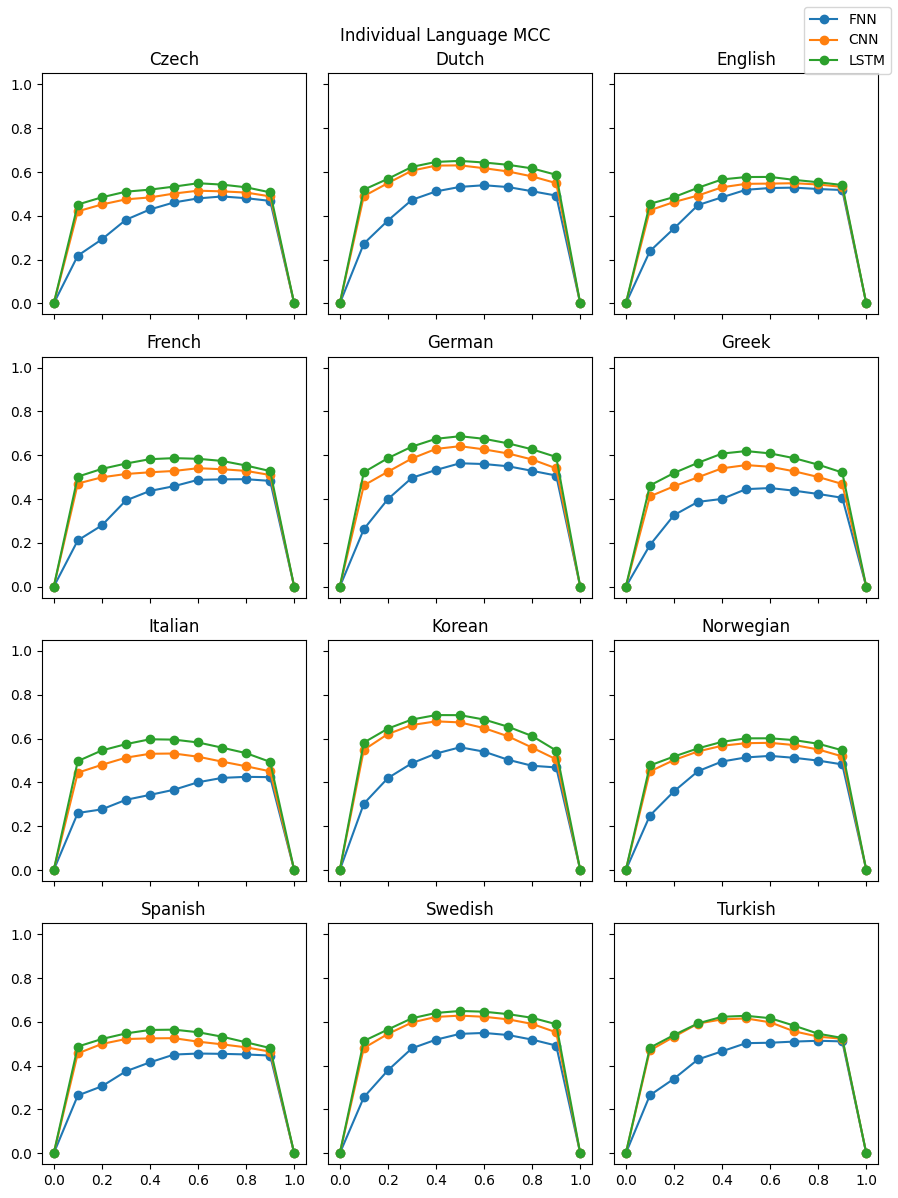

In [ ]:
#@title Plot Results

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(9,12))

for i in range(4):
  for j in range(3):
    k = i * 3 + j

    axs[i,j].plot(thresholds, lang_metrics.loc[('FNN', names[k]), 'MCC'], label='FNN', marker='o')
    axs[i,j].plot(thresholds, lang_metrics.loc[('CNN', names[k]), 'MCC'], label='CNN', marker='o')
    axs[i,j].plot(thresholds, lang_metrics.loc[('LSTM',names[k]), 'MCC'], label='LSTM', marker='o')
    axs[i,j].set_title(names[k])
    axs[i,j].set_ylim([-0.05,1.05])

fig.suptitle("Individual Language MCC")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig('Individual Language Metrics.png')
plt.show()

## Leave One Out Models (Original Size)

These models were trained on a Leave One Out (LOO) dataset that included all-but-one language, and then tested on the left-out language. The remaining training languages were sampled to produce a training dataset the same size as the All-Language dataset (502,994 words), though the percentage of each language differed from the original dataset due to the exclusion of the left-out language. The test dataset used the entirety of words in the left-out language, thus ranging from 15,259 words (Turkish) to 117,237 (Dutch).

In [ ]:
#@title MCC

loo_results = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/All Lang Size Datasets'

# Saved to CSV and loaded below.
'''
fnn_mcc = []
cnn_mcc = []
lstm_mcc = []

for i, lang in enumerate(names):

  fnn_df = pd.read_csv(os.path.join(loo_results, f'FNN_No_{lang}.csv'))
  cnn_df = pd.read_csv(os.path.join(loo_results, f'CNN_No_{lang}.csv'))
  lstm_df = pd.read_csv(os.path.join(loo_results, f'LSTM_No_{lang}.csv'))

  assert (fnn_df['Ground Truths'] == cnn_df['Ground Truths']).all()
  assert (cnn_df['Ground Truths'] == lstm_df['Ground Truths']).all()

  truths = [truth for truth in fnn_df['Ground Truths']]

  for t in thresholds:
    fnn_pred = [int(pred) for pred in fnn_df['Predictions'] > t]
    cnn_pred = [int(pred) for pred in cnn_df['Predictions'] > t]
    lstm_pred = [int(pred) for pred in lstm_df['Predictions'] > t]

    fnn_mcc.append(matthews_corrcoef(truths, fnn_pred))
    cnn_mcc.append(matthews_corrcoef(truths, cnn_pred))
    lstm_mcc.append(matthews_corrcoef(truths, lstm_pred))

mcc = fnn_mcc + cnn_mcc + lstm_mcc
index = pd.MultiIndex.from_product([models, names, thresholds], names=['Model','Language','Threshold'])
loo_metrics = pd.DataFrame(mcc, index=index, columns=['MCC']).sort_index()

loo_metrics.to_csv(os.path.join(results_folder, 'Metrics', 'LOO_Metrics.csv'))
'''
loo_metrics = pd.read_csv(os.path.join(results_folder, 'Metrics', 'LOO_Metrics.csv'),
                          index_col=['Model','Language','Threshold'])

loo_metrics

MCC
Model Language Threshold      
CNN   Czech    0.0        0.00
               0.1        0.37
               0.2        0.39
               0.3        0.39
               0.4        0.39
...                        ...
LSTM  Turkish  0.6        0.51
               0.7        0.50
               0.8        0.50
               0.9        0.51
               1.0        0.00

[396 rows x 1 columns]

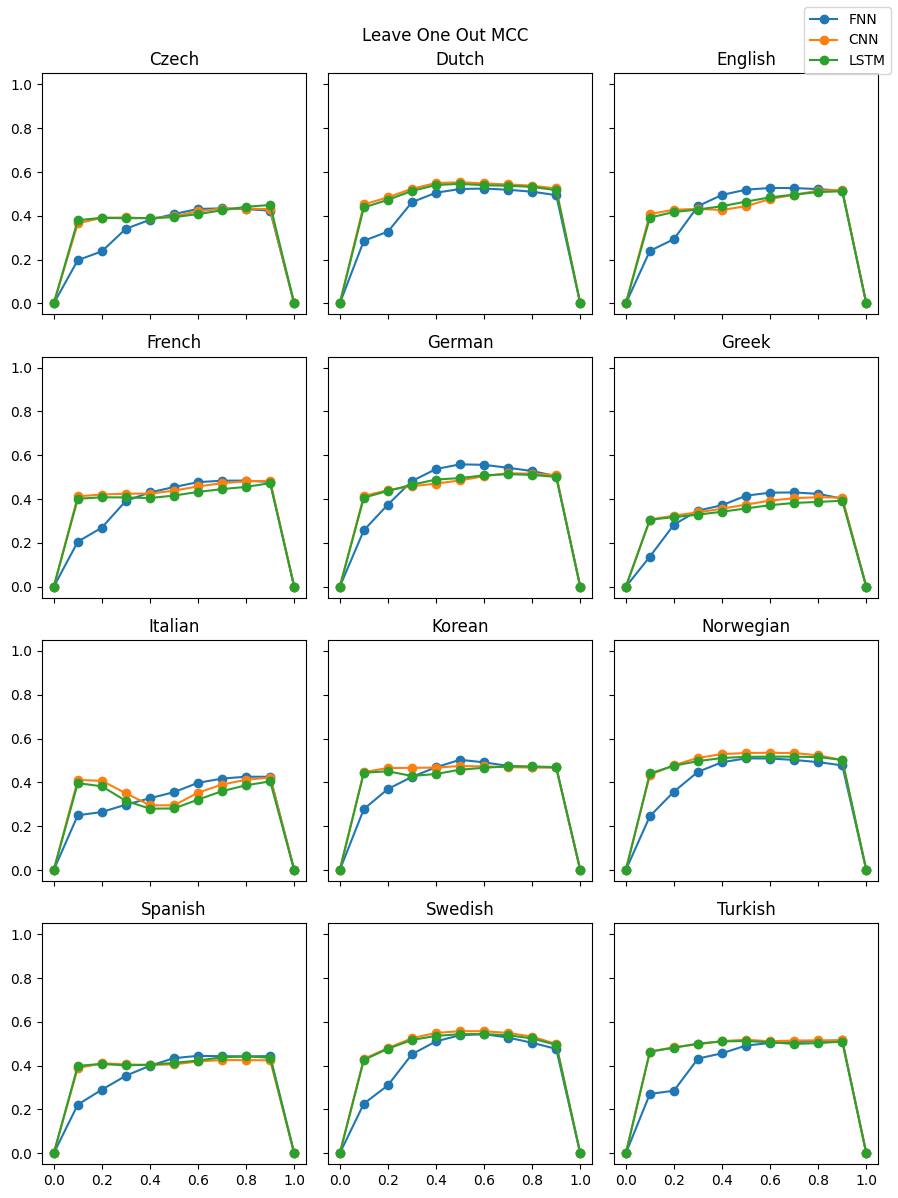

In [ ]:
#@title Plot Results

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(9,12))

for i in range(4):
  for j in range(3):
    k = i * 3 + j

    axs[i,j].plot(thresholds, loo_metrics.loc[('FNN', names[k]),'MCC'], label='FNN', marker='o')
    axs[i,j].plot(thresholds, loo_metrics.loc[('CNN', names[k]),'MCC'], label='CNN', marker='o')
    axs[i,j].plot(thresholds, loo_metrics.loc[('LSTM', names[k]),'MCC'], label='LSTM', marker='o')
    axs[i,j].set_title(names[k])
    axs[i,j].set_ylim([-0.05,1.05])

fig.suptitle("Leave One Out MCC")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig('LOO Metrics.png')
plt.show()

## Leave One Out Models (Uniform Size)

These models were also trained on a Leave One Out (LOO) datasets, but with all languages sampled to a uniform size of 15,000 (based on the smallest language of Turkish, 15,259 words). Thus all training sets had 165,000 words with equal representation of all-but-one languages, and all test sets had 15,000 words of the left-out language. These models were also trained for fewer epochs, 10 vs 30, which may have helped them, as most LOO models exhibited signs of overfitting almost immediately and continued to worsen on the left-out language while improving on the training languages.

In [ ]:
#@title MCC

loo_uniform = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/Uniform Size Datasets'

# Saved to CSV and loaded below.
'''
fnn_mcc = []
cnn_mcc = []
lstm_mcc = []

for i, lang in enumerate(names):

  fnn_df = pd.read_csv(os.path.join(loo_uniform, f'FNN_No_{lang}.csv'))
  cnn_df = pd.read_csv(os.path.join(loo_uniform, f'CNN_No_{lang}.csv'))
  lstm_df = pd.read_csv(os.path.join(loo_uniform, f'LSTM_No_{lang}.csv'))

  assert (fnn_df['Ground Truths'] == cnn_df['Ground Truths']).all()
  assert (cnn_df['Ground Truths'] == lstm_df['Ground Truths']).all()

  truths = [truth for truth in fnn_df['Ground Truths']]

  for t in thresholds:
    fnn_pred = [int(pred) for pred in fnn_df['Predictions'] > t]
    cnn_pred = [int(pred) for pred in cnn_df['Predictions'] > t]
    lstm_pred = [int(pred) for pred in lstm_df['Predictions'] > t]

    fnn_mcc.append(matthews_corrcoef(truths, fnn_pred))
    cnn_mcc.append(matthews_corrcoef(truths, cnn_pred))
    lstm_mcc.append(matthews_corrcoef(truths, lstm_pred))

mcc = fnn_mcc + cnn_mcc + lstm_mcc
index = pd.MultiIndex.from_product([models, names, thresholds], names=['Model','Language','Threshold'])
loo_uniform_metrics = pd.DataFrame(mcc, index=index, columns=['MCC']).sort_index()

loo_uniform_metrics.to_csv(os.path.join(results_folder, 'Metrics', 'LOO_Uniform_Metrics.csv'))
'''
loo_uniform_metrics = pd.read_csv(os.path.join(results_folder, 'Metrics', 'LOO_Uniform_Metrics.csv'),
                                  index_col=['Model','Language','Threshold'])

loo_uniform_metrics

MCC
Model Language Threshold      
CNN   Czech    0.0        0.00
               0.1        0.37
               0.2        0.39
               0.3        0.39
               0.4        0.39
...                        ...
LSTM  Turkish  0.6        0.53
               0.7        0.53
               0.8        0.52
               0.9        0.52
               1.0        0.00

[396 rows x 1 columns]

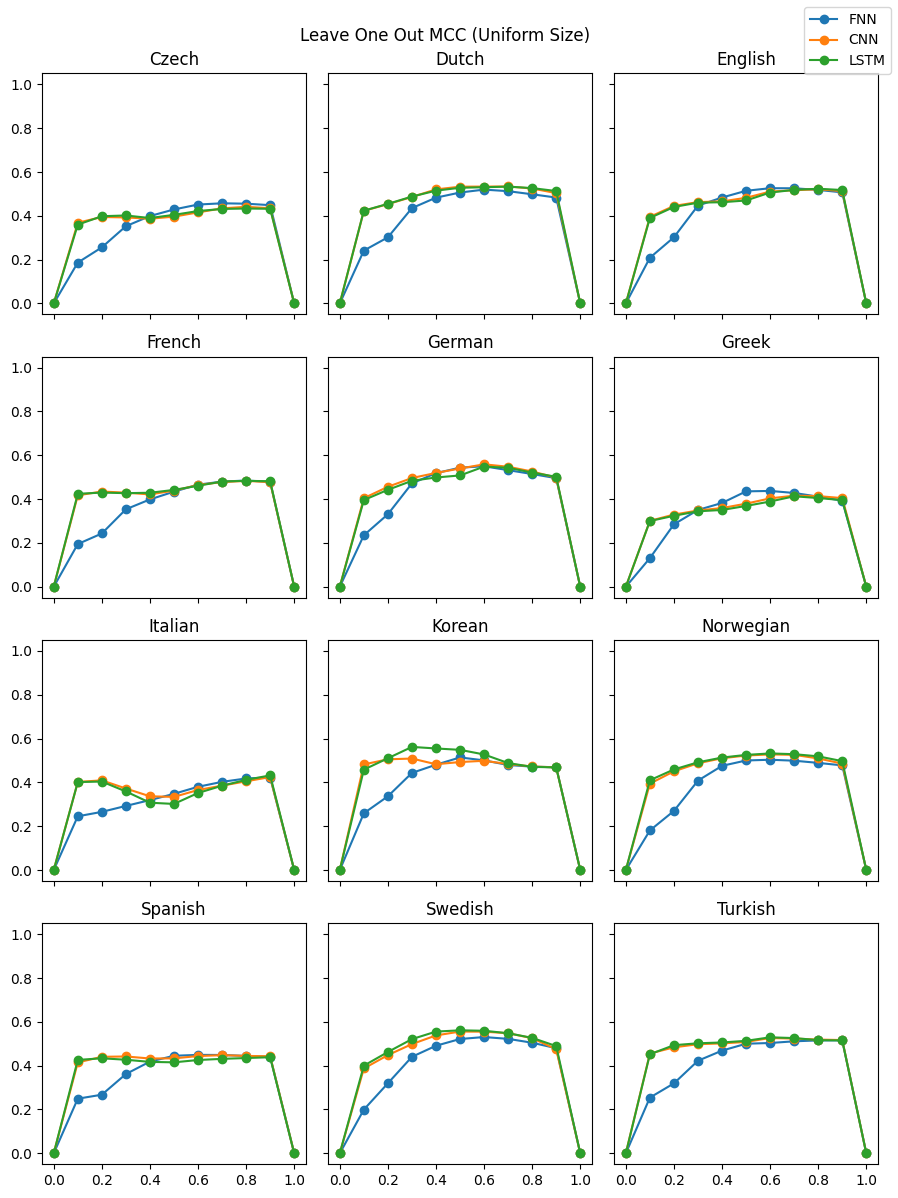

In [ ]:
#@title Plot Results

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(9,12))

for i in range(4):
  for j in range(3):
    k = i * 3 + j

    axs[i,j].plot(thresholds, loo_uniform_metrics.loc[('FNN', names[k]), 'MCC'], label='FNN', marker='o')
    axs[i,j].plot(thresholds, loo_uniform_metrics.loc[('CNN', names[k]), 'MCC'], label='CNN', marker='o')
    axs[i,j].plot(thresholds, loo_uniform_metrics.loc[('LSTM', names[k]), 'MCC'], label='LSTM', marker='o')
    axs[i,j].set_title(names[k])
    axs[i,j].set_ylim([-0.05,1.05])

fig.suptitle("Leave One Out MCC (Uniform Size)")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig('LOO Uniform Metrics.png')
plt.show()

# All Lang vs LOO Comparison

These plots compare each model's performance with the All Languages vs Leave One Out vs LOO Uniform datasets. Bear in mind that all of these models were not only trained on different datasets, but tested on different datasets as well. The All Languages models were tested on a subset of the original All Languages test dataset, the Leave One Out models were tested on the entire left-out anguage, and the LOO Uniform models were tested on a 15,000 word subset of the left-out language.

For a final comparison, it might be better to compare two models on the same test dataset, though this is only possible with the All Languages models and the Leave One Out models; since the latter were trained on all words in the left-out language, we could extract only those results on the words also included in the All Languages test subset. This is something to consider for the paper.

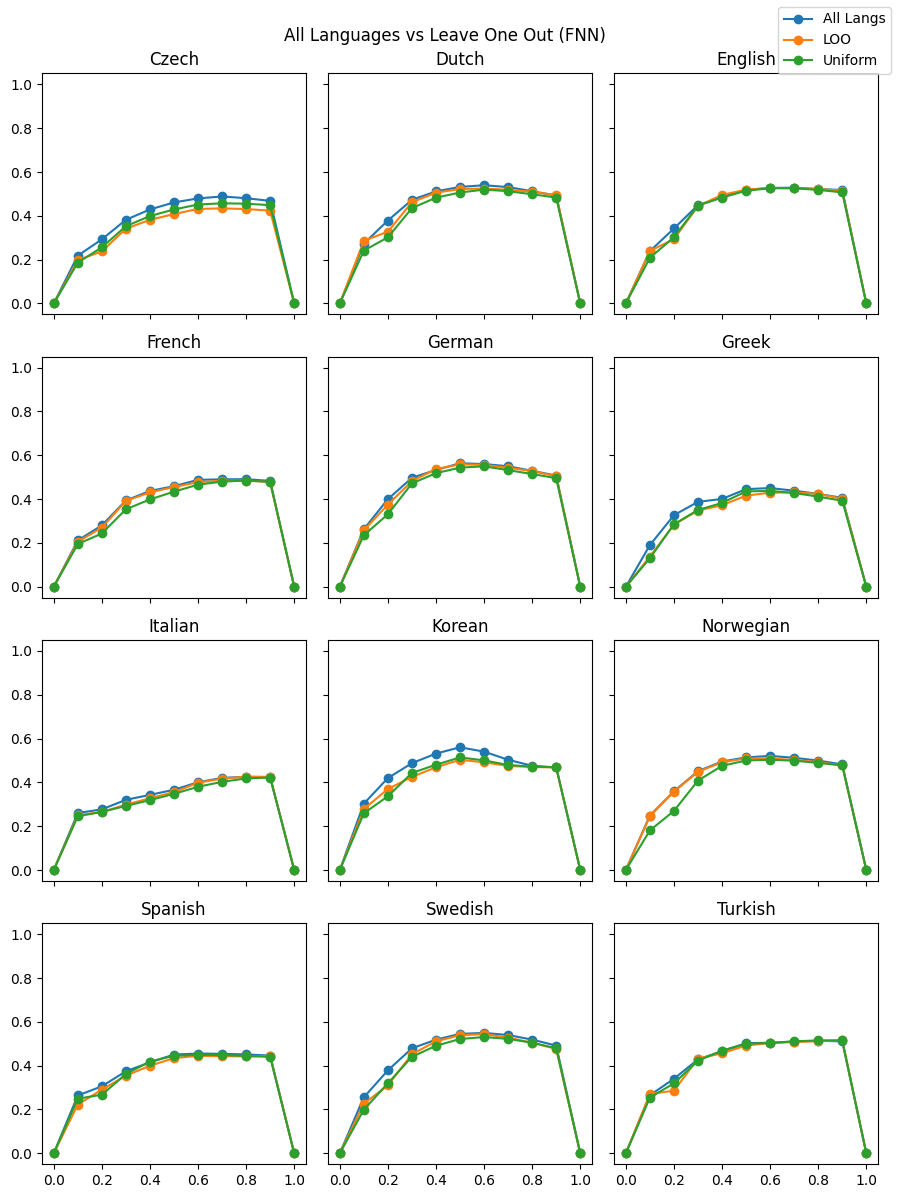

In [ ]:
#@title FNN

#@title Plot Results

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(9,12))

for i in range(4):
  for j in range(3):
    k = i * 3 + j

    axs[i,j].plot(thresholds, lang_metrics.loc[('FNN', names[k]),'MCC'], label='All Langs', marker='o')
    axs[i,j].plot(thresholds, loo_metrics.loc[('FNN', names[k]),'MCC'], label='LOO', marker='o')
    axs[i,j].plot(thresholds, loo_uniform_metrics.loc[('FNN', names[k]),'MCC'], label='Uniform', marker='o')
    axs[i,j].set_title(names[k])
    axs[i,j].set_ylim([-0.05,1.05])

fig.suptitle("All Languages vs Leave One Out (FNN)")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig('FNN LOO Comparison.png')
plt.show()

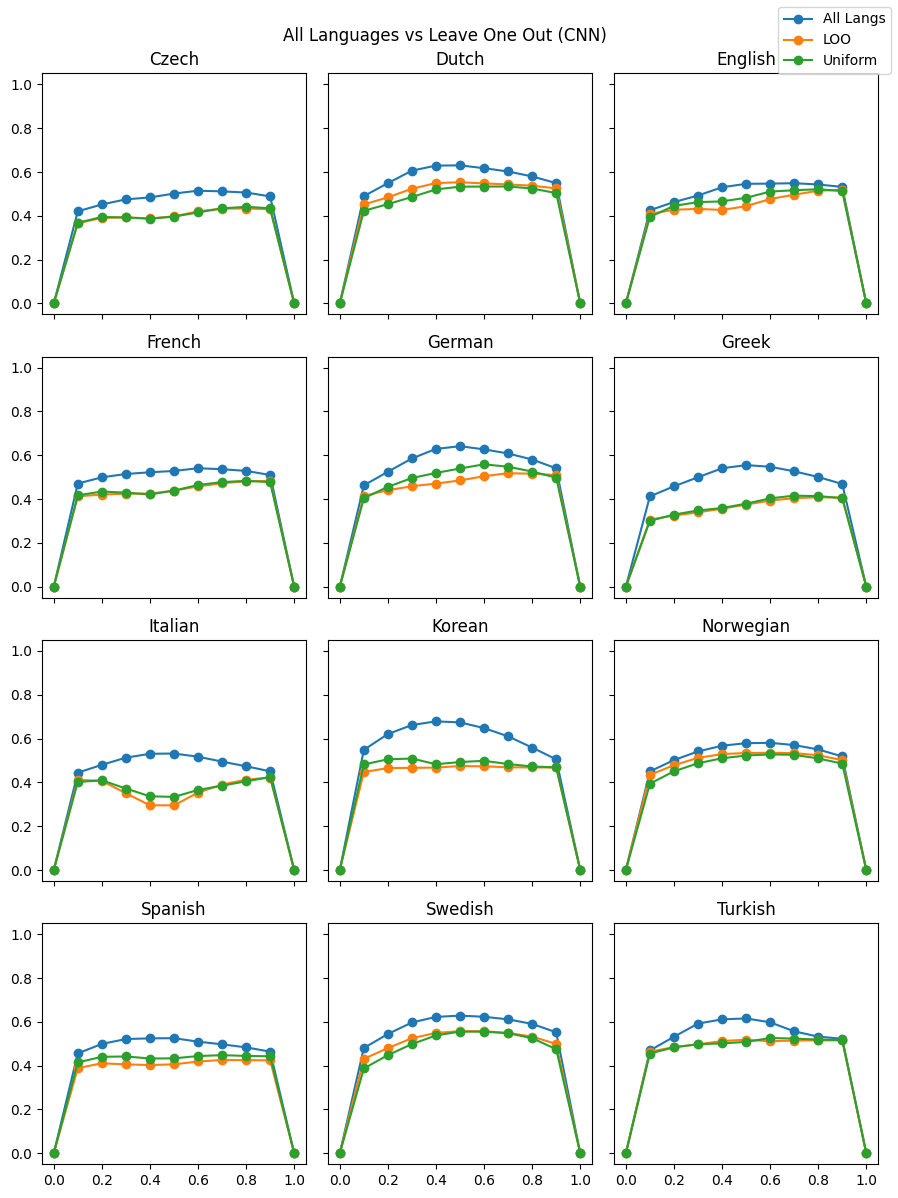

In [ ]:
#@title CNN

#@title Plot Results

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(9,12))

for i in range(4):
  for j in range(3):
    k = i * 3 + j

    axs[i,j].plot(thresholds, lang_metrics.loc[('CNN', names[k]),'MCC'], label='All Langs', marker='o')
    axs[i,j].plot(thresholds, loo_metrics.loc[('CNN', names[k]),'MCC'], label='LOO', marker='o')
    axs[i,j].plot(thresholds, loo_uniform_metrics.loc[('CNN', names[k]),'MCC'], label='Uniform', marker='o')
    axs[i,j].set_title(names[k])
    axs[i,j].set_ylim([-0.05,1.05])

fig.suptitle("All Languages vs Leave One Out (CNN)")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig('CNN LOO Comparison.png')
plt.show()

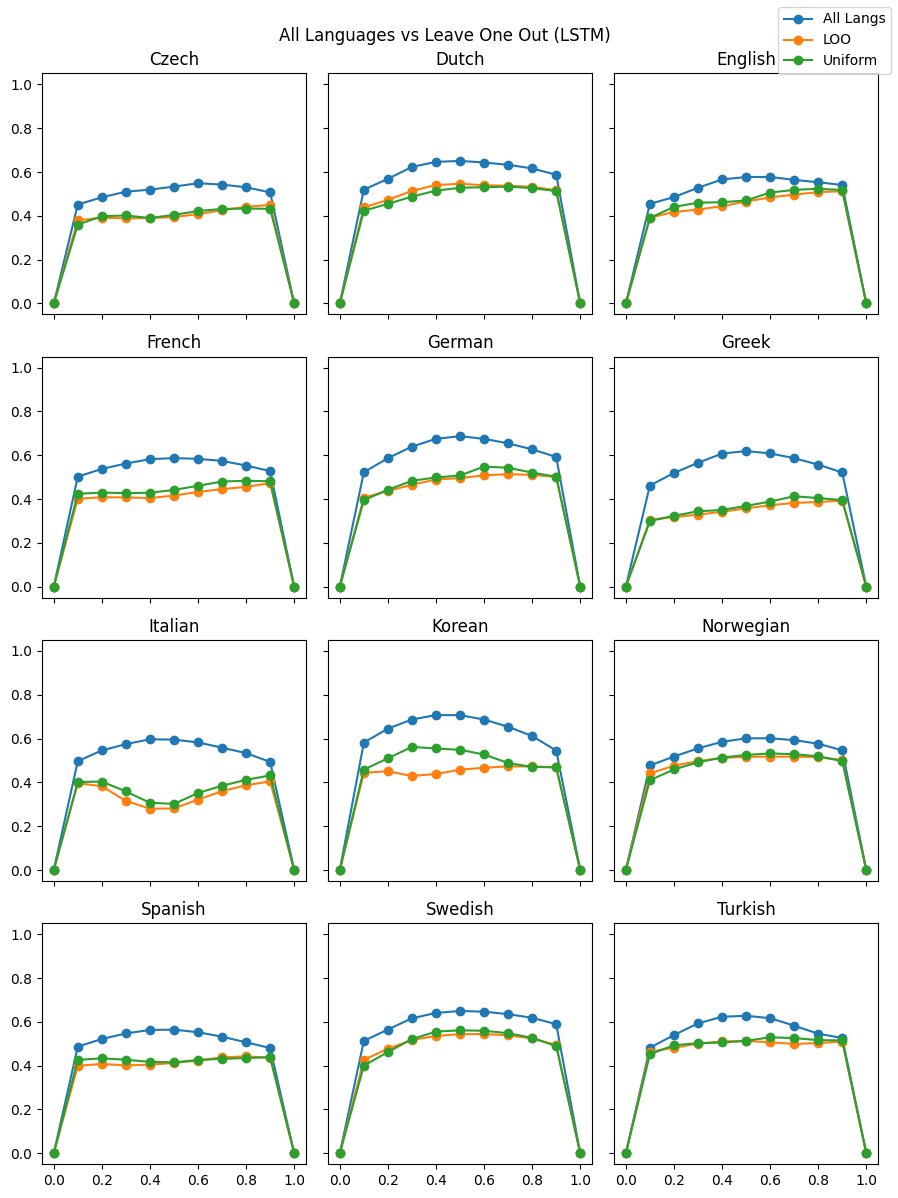

In [ ]:
#@title LSTM

#@title Plot Results

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(9,12))

for i in range(4):
  for j in range(3):
    k = i * 3 + j

    axs[i,j].plot(thresholds, lang_metrics.loc[('LSTM', names[k]),'MCC'], label='All Langs', marker='o')
    axs[i,j].plot(thresholds, loo_metrics.loc[('LSTM', names[k]),'MCC'], label='LOO', marker='o')
    axs[i,j].plot(thresholds, loo_uniform_metrics.loc[('LSTM', names[k]),'MCC'], label='Uniform', marker='o')
    axs[i,j].set_title(names[k])
    axs[i,j].set_ylim([-0.05,1.05])

fig.suptitle("All Languages vs Leave One Out (LSTM)")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig('LSTM LOO Comparison.png')
plt.show()

# Language Families

These models were trained in a LOO fashion, but instead of training on all but one language in the overall dataset, we split up languages into language families, specifically Germanic (Dutch, English, German), Romance (French, Italian, Spanish), and Nordic (Norwegian, Swedish). We trained on one or two languages in the family and tested on the left-out language. The purpose is to see if models trained on *similar* (but still not identical) languages outperform models trained on a larger swath of languages.

All languages were left at their original sizes. Because the training datasets were significantly smaller (consisting of only one or two languages), we only trained for 10 epochs to prevent overfitting. As mentioned above, this might benefit the models, as even on full-size datasets they showed evidence of overfitting almost immediately.

In [ ]:
#@title MCC

family_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/Family Results'

germanic = ['Dutch', 'English', 'German']
romantic = ['French', 'Italian', 'Spanish']
nordic = ['Norwegian', 'Swedish']
families = [('Germanic', germanic), ('Romantic', romantic), ('Nordic', nordic)]

# Saved to CSV and loaded below.
'''
temp_metrics = []

for family, family_list in families:

  fnn_mcc = []
  cnn_mcc = []
  lstm_mcc = []

  for i, lang in enumerate(family_list):

    fnn_df = pd.read_csv(os.path.join(family_folder, f'FNN_{family}_{lang}.csv'))
    cnn_df = pd.read_csv(os.path.join(family_folder, f'CNN_{family}_{lang}.csv'))
    lstm_df = pd.read_csv(os.path.join(family_folder, f'LSTM_{family}_{lang}.csv'))

    assert (fnn_df['Ground Truths'] == cnn_df['Ground Truths']).all()
    assert (cnn_df['Ground Truths'] == lstm_df['Ground Truths']).all()

    truths = [truth for truth in fnn_df['Ground Truths']]

    for t in thresholds:
      fnn_pred = [int(pred) for pred in fnn_df['Predictions'] > t]
      cnn_pred = [int(pred) for pred in cnn_df['Predictions'] > t]
      lstm_pred = [int(pred) for pred in lstm_df['Predictions'] > t]

      fnn_mcc.append(matthews_corrcoef(truths, fnn_pred))
      cnn_mcc.append(matthews_corrcoef(truths, cnn_pred))
      lstm_mcc.append(matthews_corrcoef(truths, lstm_pred))

  mcc = fnn_mcc + cnn_mcc + lstm_mcc
  index = pd.MultiIndex.from_product([[family], models, family_list, thresholds], names=['Family', 'Model','Language','Threshold'])
  temp_metrics.append(pd.DataFrame(mcc, index=index, columns=['MCC']))

family_metrics = pd.concat(temp_metrics).sort_index()

family_metrics.to_csv(os.path.join(results_folder, 'Metrics', 'Family_Metrics.csv'))
'''
family_metrics = pd.read_csv(os.path.join(results_folder, 'Metrics', 'Family_Metrics.csv'),
                          index_col=['Family','Model','Language','Threshold'])

family_metrics

MCC
Family   Model Language Threshold      
Germanic CNN   Dutch    0.0        0.00
                        0.1        0.45
                        0.2        0.51
                        0.3        0.54
                        0.4        0.55
...                                 ...
Romantic LSTM  Spanish  0.6        0.47
                        0.7        0.46
                        0.8        0.45
                        0.9        0.45
                        1.0        0.00

[264 rows x 1 columns]

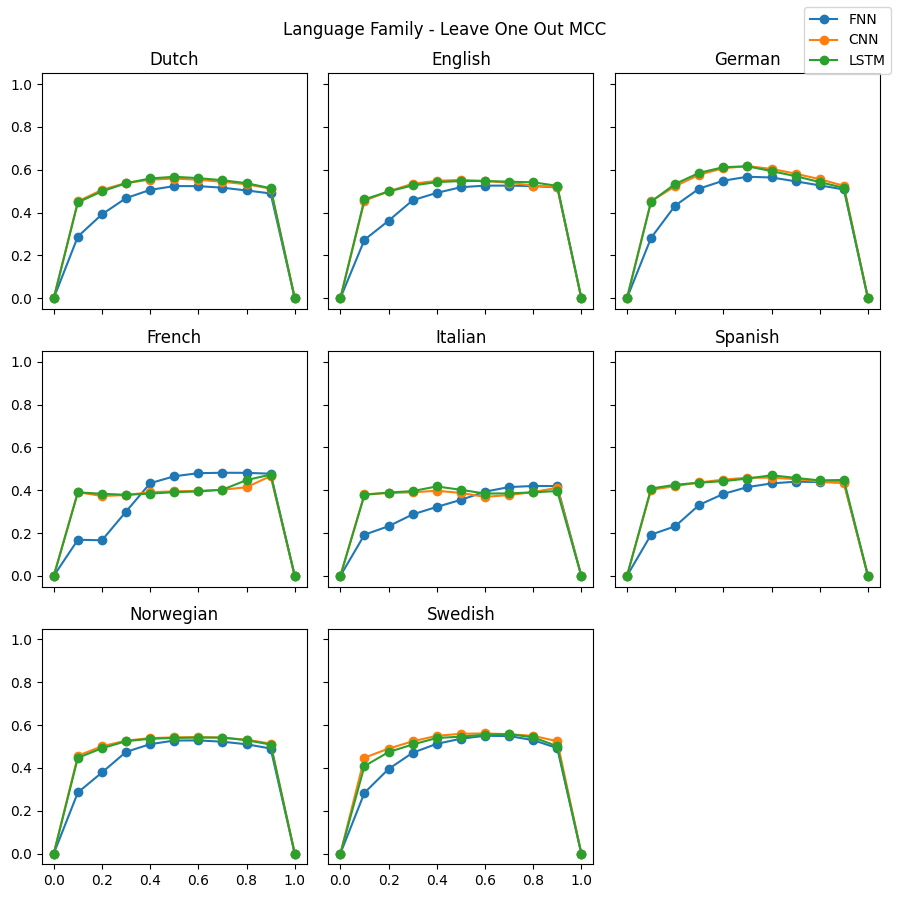

In [ ]:
#@title Plot Results

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(9,9))

for i, (family, family_list) in enumerate(families):
  for j in range(len(family_list)):

    axs[i,j].plot(thresholds, family_metrics.loc[(family, 'FNN', family_list[j]), 'MCC'], label='FNN', marker='o')
    axs[i,j].plot(thresholds, family_metrics.loc[(family, 'CNN', family_list[j]), 'MCC'], label='CNN', marker='o')
    axs[i,j].plot(thresholds, family_metrics.loc[(family, 'LSTM', family_list[j]), 'MCC'], label='LSTM', marker='o')
    axs[i,j].set_title(family_list[j])
    axs[i,j].set_ylim([-0.05,1.05])

axs[2,2].set_axis_off()

fig.suptitle("Language Family - Leave One Out MCC")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig('Language Family Metrics.png')
plt.show()

# Investigate differences between models trained on CPU vs GPU

When training a CNN on CPU vs GPU, I noticed some drastic changes in the training and validation performances. When training FNNs on CPU vs GPU, results looked identical. I look into this below.

There are in fact differences when training models on CPU vs GPU for both FNNs and CNNs, though the differences are far more significant for CNNs. On the FNN, maximum difference in predictions between CPU-trained models and GPU-trained models was 0.002, meaning extremely few if any predictions would flip from 0 to 1 based on how the model was trained. On the CNN, differences were often greater than 0.5, meaning these predictions definitely would be flipped between models.

There are certain functions in the CNN that do not allow it to use "deterministic processes" while training on GPU, which might explain its greater divergence when training on GPU vs CPU.

Also, the language that seemed most prone to differences between CPU and GPU for the FNN was Czech, and this was the *only* language trained on both CPU and GPU for the CNN. This might be because it was the first language on the list, and so how it ran depended somewhat more on how earlier cells in the notebook were run, which might differ between sessions.

It would probably be worth retraining the CNNs on GPU (for speed) and comparing their predictions across different training runs, to get a better sense of how variable this is. It might also be worth doing this with the LSTMs.

In [ ]:
#@title FNN Differences

main_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/All Lang Size Datasets'
cpu_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/All Lang Size Datasets/CPU'
gpu_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/All Lang Size Datasets/GPU'

for lang in names[1:]:
  main_df = pd.read_csv(os.path.join(main_folder, f'FNN_No_{lang}.csv'))
  cpu_df = pd.read_csv(os.path.join(cpu_folder, f'FNN_No_{lang}.csv'))
  gpu_df = pd.read_csv(os.path.join(gpu_folder, f'FNN_No_{lang}.csv'))

  assert np.isclose(main_df['Predictions'], cpu_df['Predictions'], atol=0.0005).all()
  assert np.isclose(main_df['Predictions'], gpu_df['Predictions'], atol=0.002).all()
  assert np.isclose(cpu_df['Predictions'], gpu_df['Predictions'], atol=0.002).all()

In [ ]:
#@title FNN Differences Cont.

main_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/All Lang Size Datasets'
cpu_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/All Lang Size Datasets/CPU'
gpu_folder = '/content/drive/MyDrive/CompLing Projects/Voynich/Data and scripts/Revised Models and Results/Results/LOO Results/All Lang Size Datasets/GPU'

print('FNN Output Differences')
print()
for lang in names:
  print(lang)
  main_df = pd.read_csv(os.path.join(main_folder, f'FNN_No_{lang}.csv'))
  cpu_df = pd.read_csv(os.path.join(cpu_folder, f'FNN_No_{lang}.csv'))
  gpu_df = pd.read_csv(os.path.join(gpu_folder, f'FNN_No_{lang}.csv'))

  print('Main vs CPU, tol=0.0004:', sum(~np.isclose(main_df['Predictions'], cpu_df['Predictions'], atol=0.0004)))
  print('Main vs GPU, tol=0.001: ', sum(~np.isclose(main_df['Predictions'], gpu_df['Predictions'], atol=0.001)))
  print('CPU  vs GPU, tol=0.001: ', sum(~np.isclose(cpu_df['Predictions'], gpu_df['Predictions'], atol=0.001)))
  print()

FNN Output Differences

Czech
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  1365
CPU  vs GPU, tol=0.001:  1365

Dutch
Main vs CPU, tol=0.0004: 9
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

English
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

French
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

German
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

Greek
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

Italian
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

Korean
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

Norwegian
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

Spanish
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  0
CPU  vs GPU, tol=0.001:  0

Swedish
Main vs CPU, tol=0.0004: 0
Main vs GPU, tol=0.001:  89
CPU  vs GPU, t

In [ ]:
#@title CNN Differences

main_df = pd.read_csv(os.path.join(main_folder, f'CNN_No_Czech.csv'))
cpu_df = pd.read_csv(os.path.join(cpu_folder, f'CNN_No_Czech.csv'))
gpu_df = pd.read_csv(os.path.join(gpu_folder, f'CNN_No_Czech.csv'))

print('CNN Output Differences')
print()
print('Czech')
print('Main vs CPU, tol=0.5:', sum(~np.isclose(main_df['Predictions'], cpu_df['Predictions'], atol=0.5)))
print('Main vs GPU, tol=0.5:', sum(~np.isclose(main_df['Predictions'], gpu_df['Predictions'], atol=0.5)))
print('CPU  vs GPU, tol=0.5:', sum(~np.isclose(cpu_df['Predictions'], gpu_df['Predictions'], atol=0.5)))

CNN Output Differences

Czech
Main vs CPU, tol=0.5: 886
Main vs GPU, tol=0.5: 905
CPU  vs GPU, tol=0.5: 699
